# Introduction

In this notebook, we use a CNN to classify pneumonia cases. The dataset in question is available at kaggle by [this link](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The problem has been solved by the use of ShuffleNet and MobileNet's previous versions before, but in this kernel we are using a small MobileNetV3 via transfer learning and then finetuning its last layers in addition to learn a new classification head. This makes this solution extremly lightweight. Stay Tuned!

# Code

In [1]:
!nvidia-smi

Sat Aug 14 08:40:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qo chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!pip install --upgrade torch-summary

In [4]:
# Set the tqdm text color to white.

from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

## Imports

In [5]:
import time
import json
from pathlib import Path

import h5py

import numpy as np
import pandas as pd
from PIL import Image
import cv2

from tqdm.auto import tqdm, trange

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, 
                             classification_report, 
                             plot_confusion_matrix,
                             ConfusionMatrixDisplay)


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms as VisTransforms
import torchvision
from torchvision.utils import draw_segmentation_masks



import matplotlib.pyplot as plt

import multiprocessing as mp


plt.style.use('ggplot')

Apparently there is a problem with pytorch 1.9's implementation of torch hub which this helps to alieviate.

In [6]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

## Defining Constants

In [7]:
RANDOM_SEED = 42
VAL_SPLIT = 0.05

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_PATH = "/content/chest_xray/chest_xray"
SAVE_LOCATION = "/content/drive/MyDrive/Self-Projects/PneumoniaAnalysis"
Path(SAVE_LOCATION).mkdir(parents=True, exist_ok=True)
IMAGE_SIZE = (256, 256)

LR = 1e-2
PRETRAINED_LR = 1e-6
MOMENTUM = 0.9
BETAS = (0.9, 0.99)
ADAM_EPS = 1e-8
WEIGHT_DECAY = 5e-2
MAX_GRADIENT_NORM = 0.5

LR_SCHEDULE_GAMMA = 0.9
T_0_COSINE_ANNEALING = 5
T_MULT_COSINE_ANNEALING = 2
ETA_MIN_COSINE_ANNEALING = 1e-8


EARLY_STOPPING_PATIENCE = 10

BATCH_SIZE = {
    "train": 64,
    "test": 128,
}

MAX_EPOCHS = 100

## Pre-training plots

### Plotting widths and heights of the images in the dataset


This helps us choose a better size (I've chosen it before;).)

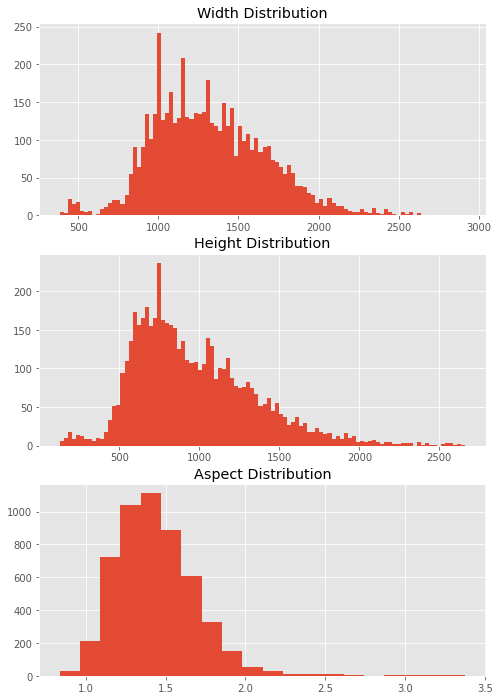

In [8]:
sizes = []
labels = []

for root, _, files in os.walk(os.path.join(DATASET_PATH, "train")):
    for f in files:
        if f.endswith(".jpeg"):
            img = Image.open(os.path.join(root, f))
            w, h = img.size
            aspect = w / h
            sizes.append((w, h, aspect))
            labels.append(Path(root).stem)


sizes = np.asarray(sizes)

w = sizes[:, 0]
h = sizes[:, 1]
a = sizes[:, 2]

fig, axes = plt.subplots(3, 1, figsize=(8,12))

axes[0].hist(w, bins=100)
axes[0].set_title("Width Distribution")
axes[1].hist(h, bins=100)
axes[1].set_title("Height Distribution")
axes[2].hist(a, bins=20)
axes[2].set_title("Aspect Distribution")
pass

### Plotting the distribution of classes and choosing adequate weightings.

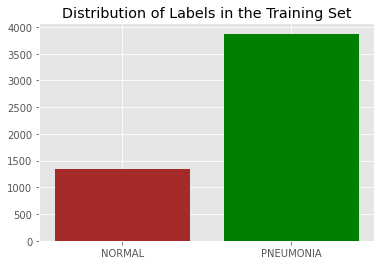

In [9]:
uniques, counts = np.unique(labels, return_counts=True)
plt.bar(uniques, counts, color=["brown", "green"])
plt.title('Distribution of Labels in the Training Set')
pass

In [10]:
n = len(labels)
n_classes = len(set(labels)) # == 2
# balanced weight formula: n_total/(n_classes * n_samples_in_ith_class)
classification_weights = {
    idx: n/(v*n_classes) for idx, (k, v) in enumerate(zip(*np.unique(labels, return_counts=True)))
}
print(classification_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


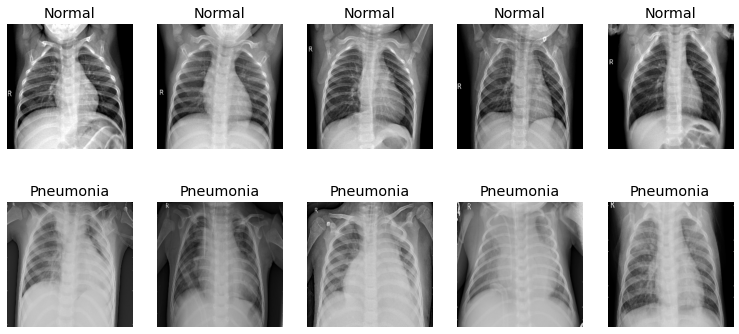

In [11]:
def display_cases(path, n = 5, seed=42):
    fpaths = []
    labels = []
    for root, _, files in os.walk(os.path.join(path, "train")):
        for f in files:
            if f.endswith(".jpeg"):
                fpaths.append(os.path.join(root, f))
                labels.append(Path(root).stem)
    
    labels_dict = {
        k: idx for idx, k in enumerate(np.unique(labels))
    }
    labels_arr = np.array([labels_dict[idx] for idx in labels])
    indices = np.arange(len(labels))

    
    random_state = np.random.default_rng(seed)
    normal_indices = random_state.choice(indices[labels_arr == 0], size=5).tolist()
    pneumonia_indices = random_state.choice(indices[labels_arr == 1], size=5).tolist()

    fig, axes = plt.subplots(2, n, figsize=(13, 6))

    axes = list(axes.flat)

    

    for ax, idx in zip(axes, normal_indices + pneumonia_indices):
        ax.grid(None)
        ax.axis('off')
        img = cv2.imread(fpaths[idx])
        img = cv2.resize(img, IMAGE_SIZE)
        ax.imshow(img)
        ax.set_title(labels[idx].capitalize())

display_cases(DATASET_PATH)

## Defining Transforms

In [12]:
class LabelTransformer:
    def __call__(self, label):
        label = label.lower()
        if label == "normal":
            return 0
        else:
            return 1

In [13]:
class ImageResizer:
    def __init__(self, size, optional=False):
        self.size = size
        self.optional = optional
    def __call__(self, input_img):
        h, w = input_img.shape
        target = cv2.resize(input_img, 
                            (self.size, self.size),  
                            interpolation = cv2.INTER_CUBIC)
        return target

In [14]:
class PreProcessor:
    def __init__(self,
                 pipeline):
        self.preprcoessing_pipeline = pipeline

    def __call__(self, input_img):
        processed = self.preprcoessing_pipeline(input_img)
        return processed        

## Defining the Dataset

In [15]:
class PneumoniaDataset(Dataset):
    def __init__(self, 
                 subset, 
                 preprocessor, 
                 image_transforms,
                 label_transforms,
                 root=DATASET_PATH,
                 debug=False):
        super().__init__()
        assert subset in ["train", "test", "val"]
        self.folder_path = os.path.join(root, subset)
        self.dataset_name = subset

        self.preprocessor = preprocessor
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

        self._save_to_hdf5(debug)
    
    def _save_to_hdf5(self, debug):
        '''
            This function saves the data into hdf5 datasets

            debug: flag to create a debug set using a limited number of samples
        '''
        images_path = []
        labels = []
        for root, __, files in os.walk(self.folder_path):
            for f in files:
                if f.endswith(".jpeg"):
                    fpath = os.path.join(root, f)
                    l = Path(root).stem
                    images_path.append(fpath)
                    labels.append(self.label_transforms(l))
                
        
        if debug:
            images_path = images_path[:50]
            labels = labels[:50]

        if os.path.exists(self.dataset_name):
            os.remove(self.dataset_name)

        hf = h5py.File(self.dataset_name, "w")

        image_dset = hf.create_dataset(
            "images", 
            chunks=True, 
            shape=(len(images_path), *IMAGE_SIZE),
            dtype=np.uint8
            )
        label_dset = hf.create_dataset(
            "labels",
            data=labels,
            chunks=True,
        )

        for idx, fpath in enumerate(tqdm(images_path, 
                                         desc=f"creating {self.dataset_name} set")):
            # reading images as grayscales
            img = cv2.imread(fpath, 0)
            img = self.preprocessor(img)
            image_dset[idx] = img
        
        
        hf.close()

        self.hf = h5py.File(self.dataset_name, "r", 
                            # 300 MB of cache
                            rdcc_nbytes=300 * (2**20), # 1MB
                            rdcc_nslots=100)

        self._len = len(images_path)

    
    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        img = self.hf["images"][idx]
        l = self.hf["labels"][idx]
        
        img = self.image_transforms(img)
        l = torch.LongTensor([l])

        return {
            "image": img,
            "label": l
        }

## Defining the Initializer

In [16]:
# We need to make sure the data is batched correctly
class BatchCollater:
    def __call__(self, data):
        batch = {k: [] for k in data[-1]}
        for d in data:
            for k in d:
                batch[k].append(d[k])
        for k in batch:
            batch[k] = torch.stack(batch[k], dim=0)
        batch["label"] = batch["label"].squeeze()
        return batch

class Initializer:
    def __init__(self):
        '''
            This class helps us initiate all the required data stuff with ease.
        '''
        pass

    
    def initialize(self, debug=False):
        preprocessor = PreProcessor(
            pipeline=VisTransforms.Compose([ImageResizer(IMAGE_SIZE[0]),])
            )
        image_transforms = VisTransforms.Compose([VisTransforms.ToTensor(),
                                                  # GrayScale mapping
                                                  VisTransforms.Lambda(
                                                      lambda x: torch.cat([x, x, x]).clone()
                                                      ),
                                                  VisTransforms.RandomChoice(
                                                      [VisTransforms.ColorJitter(
                                                          brightness=0.2,
                                                          contrast=0.2,
                                                          ),
                                                       VisTransforms.RandomAffine(
                                                           degrees=10, 
                                                           shear=2,
                                                           translate=(0.1, 0.1)
                                                           ),
                                                       VisTransforms.RandomHorizontalFlip(
                                                           p=1),
                                                       ],),
                                                  VisTransforms.Normalize(
                                                      mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]
                                                      )])
        label_transforms = LabelTransformer()

        train_dataset = PneumoniaDataset("train", 
                                         preprocessor, 
                                         image_transforms, 
                                         label_transforms, 
                                         debug=debug)

        val_dataset = PneumoniaDataset("val", 
                                       preprocessor, 
                                       image_transforms, 
                                       label_transforms, 
                                       debug=debug)

        test_dataset = PneumoniaDataset("test", 
                                        preprocessor, 
                                        image_transforms, 
                                        label_transforms, 
                                        debug=debug)

        train_loader = DataLoader(
            dataset=train_dataset, 
            batch_size=BATCH_SIZE["train"], 
            shuffle=True, 
            num_workers=2,
            collate_fn=BatchCollater(),
            prefetch_factor=2,
        )

        test_loader_params = val_loader_params = dict(batch_size=BATCH_SIZE["test"],
                                                      collate_fn=BatchCollater(), 
                                                      shuffle=False,)
        

        val_loader = DataLoader(dataset=val_dataset, **val_loader_params)
        test_loader = DataLoader(dataset=test_dataset, **test_loader_params)

        return dict(
            train_dataset=train_dataset,
            train_loader=train_loader,
            val_dataset=val_dataset,
            val_loader=val_loader,
            test_dataset=test_dataset,
            test_loader=test_loader,
        )

In [17]:
# From https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5

import torch.nn.init as init


def weight_init(m):
    '''
    Initializes the weights of a module.
    
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

## Defining the PneumoniaNet

This CNN uses a small MobileNetV3 architecture, and freezes all but its the last two modules which are then are finetuned via a smaller learning rate than the classification head. The last two modules are An inverted residual module + a 1x1 convolution module. This makes the model extremly lightweight to use and extremly resistant to overfitting because of the lack of parameters.

In [18]:
def load_pretrained():
    pretrained_model = torchvision.models.mobilenetv3.mobilenet_v3_small(pretrained=True,
                                                                         progress=True)
    return pretrained_model.features


class PneumoniaNet(nn.Module):
    def __init__(self, 
                 input_dim,
                 finetune=False):
        
        super().__init__()

        self.loss_fn = nn.CrossEntropyLoss(
            weight=torch.FloatTensor(list(classification_weights.values()))
            )

        self.input_dim = torch.as_tensor(input_dim)
        
        self.input_encoder = load_pretrained()

        # Freezing all layers but the last two
        for param in self.input_encoder[:-2].parameters():
            param.requires_grad = False

        self.output_decoder = nn.Sequential(        
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(576, 2),
        )

        self._init_weights()


    def _init_weights(self):
        self.output_decoder.apply(weight_init)
        

    def forward(self, x):
        assert x.shape[-2] == self.input_dim[0] and x.shape[-1] == self.input_dim[1]

        x = self.input_encoder(x)
        x = self.output_decoder(x)

        return x


    def loss(self, outputs, targets):
        return self.loss_fn(outputs, targets)
        


    def generate_opt(self):
        params = [
                  {"params": nn.ModuleList([self.output_decoder]).parameters()},
                  {"params": self.input_encoder[-2:].parameters(), "lr": PRETRAINED_LR,}
        ]
        
        return torch.optim.AdamW(
                params,
                lr=LR,
                weight_decay=WEIGHT_DECAY,
                betas=BETAS,
                eps=ADAM_EPS
        )


### Defining EarlyStopping

In [18]:
# From https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping:
    def __init__(self, mode='min', 
                 min_delta=0, 
                 patience=EARLY_STOPPING_PATIENCE,
                 percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        # This helps us saving the model
        # whenever this is true we will save the model
        self.testing_patience = False

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def stop(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            self.testing_patience = True
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.testing_patience = False
        else:
            self.num_bad_epochs += 1
            self.testing_patience = True

        if self.num_bad_epochs >= self.patience:
            self.testing_patience = True
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

## Defining the Trainer Class

These are a bunch of helper functions and classes, just to use in the trainer class. The most intersting point is that we are using a CosineAnnealing learning rate scheme that has warmups every few steps with a dynamic cyclical routine. The cycle lengthens everytime it completes a new one. 

In [19]:
def compute_f1(outputs, targets):
    binary_outputs = outputs.argmax(dim=-1).detach().cpu().squeeze().numpy()
    targets = targets.detach().cpu().squeeze().numpy()
    return f1_score(targets, binary_outputs)

# A Simple Helper class to circumvent sklearn's need for classifiers
class IdentityClassifier:
    def __init__(self):
        self._estimator_type = 'classifier'
        self._classes = [0, 1]

    def predict(self, X):
        return X

def classification_report_string_with_dict(**params):
    if "output_dict" in params:
        params.pop("output_dict")
    return classification_report(**params), classification_report(output_dict=True, **params)


As I mentioned above, we use LR scheduling (cosine annealing with warm restarts) and early stopping regularizations, which chooses the best model by it's validation loss value.

In [20]:
class Trainer:
    def __init__(self,
                 model,
                 model_name,
                 train_loader,
                 val_loader,
                 test_loader,
                 max_epochs=MAX_EPOCHS,
                 amp=True,
                 device=device):
    
        self.device = device
        self.model = model

        self.opt = self.model.generate_opt()

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.opt,
            T_0_COSINE_ANNEALING,
            T_MULT_COSINE_ANNEALING,
            verbose = False,
        )

        self.stopper = EarlyStopping()

        self.cur_epoch = 1
        self.max_epochs = max_epochs

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        self.model_name = model_name
        self.save_loc = os.path.join(SAVE_LOCATION, model_name)
        

        self.training_info = []

        self.amp = amp

        self.debug = False

    @property
    def debug(self):
        return self._debug

    @property
    def amp(self):
        return self._amp
    
    @amp.setter
    def amp(self, flag):
        self._amp = flag
        self.scaler = torch.cuda.amp.GradScaler(enabled=self._amp)


    @debug.setter
    def debug(self, flag):
        self._debug = flag
        if flag is False:
            if hasattr(self, "original_values"):
                for item in self.original_values:
                    self.__dict__[item] = self.original_values[item]
        else:
            self.original_values = {
                "train_loader": self.train_loader,
                "val_loader": self.val_loader,
                "test_loader": self.test_loader,
                "max_epochs": self.max_epochs,
            }
            self.train_loader = DataLoader(self.train_loader.dataset, 
                                           batch_size=2,
                                           shuffle=False,
                                           num_workers=2,
                                           collate_fn=BatchCollater(),
                                           prefetch_factor=2)
            
            self.val_loader = DataLoader(self.val_loader.dataset, 
                                         collate_fn=BatchCollater(),
                                         batch_size=4,
                                         shuffle=False)
            
            self.test_loader = DataLoader(self.test_loader.dataset, 
                                          collate_fn=BatchCollater(),
                                          batch_size=4,
                                          shuffle=False)
            self.max_epochs = 1


    @property
    def save_loc(self):
        return self._save_loc

    @save_loc.setter
    def save_loc(self, path):
        
        self.model_save_location = os.path.join(path, f"saved_model.model")
        self.training_info_location = os.path.join(path, "training_info.json")
        self.test_info_location = os.path.join(path, "test_info.json")

        self._save_loc = path
        Path(self._save_loc).mkdir(exist_ok=True)


    def save_model(self):
        state_dict = {
            "training_info": self.training_info,
            "model_state": self.model.state_dict(),
            "opt_state": self.opt.state_dict(),
            "scaler_state": self.scaler.state_dict()
        }

        torch.save(state_dict, self.model_save_location)


    def save_training_info(self):
        with open(self.training_info_location, "w") as jfile:
            json.dump(self.training_info, jfile)

    def load_model(self):
        state_dict = torch.load(self.model_save_location)
        self.training_info = state_dict["training_info"]
        self.model.load_state_dict(state_dict["model_state"])
        self.opt.load_state_dict(state_dict["opt_state"])
        self.scaler.load_state_dict(state_dict["scaler_state"])

        
    def validate(self):
        running_info = {
                    "loss": 0,
                    "f1": 0,
                    "numel": 0,
        }
        self.model.eval()
        with torch.no_grad():
            for batch in self.val_loader:
                for k in batch:
                    batch[k] = batch[k].to(self.device)

                outputs = self.model(batch["image"])
                loss = self.model.loss(outputs, batch["label"])

                batch_size = len(batch["image"])
                running_info["loss"] += loss.item() * batch_size
                running_info["f1"] += compute_f1(outputs, batch["label"]) * batch_size
                running_info["numel"] += batch_size
            
        val_info = {
            f"val_loss": running_info["loss"] / running_info["numel"],
            f"val_f1": running_info["f1"] / running_info["numel"]
        }

        return val_info

    def test(self):
        outputs = []
        targets = []
        self.model.eval()
        loss = 0
        with torch.no_grad():
            for batch in self.test_loader:
                for k in batch:
                    batch[k] = batch[k].to(self.device)

                o = self.model(batch["image"])

                loss += self.model.loss(o, batch["label"]).item() * len(batch["label"])

                outputs.extend(o.argmax(dim=-1).detach().cpu().tolist())
                targets.extend(batch["label"].detach().cpu().tolist())
                
        outputs = (np.asarray(outputs) > 0.5).astype(np.int)
        targets = np.asarray(targets).astype(np.int)
        
        report, test_info = classification_report_string_with_dict(
                y_true=targets,
                y_pred=outputs,
                target_names = ["Normal", "Pneumonia"],
            )
        
        
        test_info["test_loss"] = loss / len(outputs)

        print(report)
        print(f"test_loss: {test_info['test_loss']}")


        fig, ax = plt.subplots()
        ax.grid(None)
        plot_confusion_matrix(IdentityClassifier(), outputs, targets,
                              display_labels=["Normal", "Pneumonia"],
                              normalize='true', 
                              values_format='.2%',
                              ax=ax)
        
        plt.show()

        with open(self.test_info_location, "w") as jfile:
            json.dump(test_info, jfile)


    def train(self):
        self.model.train()
        begin = True
        for epoch in range(self.cur_epoch, self.max_epochs+1):
            running_info = {
                    "loss": 0,
                    "f1": 0,
                    "numel": 0,
                }
            pbar = tqdm(total=len(self.train_loader), 
                        desc= f"Epoch {epoch} out of {self.max_epochs}.",
                        leave=False)

            for batch in self.train_loader:
                for k in batch:
                    batch[k] = batch[k].to(self.device)

                self.opt.zero_grad()
                with torch.cuda.amp.autocast(enabled=self.amp):
                    outputs = self.model(batch["image"])
                    loss = self.model.loss(outputs, batch["label"])
            
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.opt)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), MAX_GRADIENT_NORM)
                self.scaler.step(self.opt)
                self.scaler.update()

                batch_size = len(batch["image"])
                batch_loss = loss.item()
                running_info["loss"] += batch_size * batch_loss
                running_info["f1"] += compute_f1(outputs, batch["label"]) * batch_size
                running_info["numel"] += batch_size

                pbar.set_postfix(batch_loss=batch_loss)
                pbar.update()
                time.sleep(0.01)
            
            self.cur_epoch = epoch
            self.scheduler.step()

            pbar.close()
            time.sleep(0.01)
            info = {
                "epoch": epoch,
                "train_loss": running_info["loss"] / running_info["numel"],
                "train_f1": running_info["f1"] / running_info["numel"],
            }
            info.update(self.validate())
            self.training_info.append(info)

            message = "\t".join([f"{k}: {v:.3f}" for k, v in info.items()])
            print(message)
            self.save_training_info()
            if self.stopper.stop(info["val_loss"]):
                break
            else:
                if self.stopper.testing_patience is False:
                    self.save_model()
            

## Training

### Intializing the datasets and the loaders

In [ ]:
initer = Initializer()
params = initer.initialize(debug=False)

### Intitializing the model and the trainer class

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
model = PneumoniaNet(input_dim=IMAGE_SIZE).to(device)
trainer = Trainer(
    model,
    "pneumonia_model",
    train_loader=params["train_loader"],
    val_loader=params["val_loader"],
    test_loader=params["test_loader"],
    amp=True,
)
print(
    f"Total learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):.2E}"
)

### Training the model

In [ ]:
trainer.train()

### Plotting the training history

In [ ]:
# Plotting loss and f1 score for train and validation
fig, axes = plt.subplots(2, 1, figsize=(7,11))

training_info = pd.DataFrame(trainer.training_info)

training_info.plot(x="epoch", 
                   y =["train_loss", "val_loss"], 
                   ax=axes[0])
axes[0].set_title("Loss During Training")

training_info.plot(x="epoch", 
                   y =["train_f1", "val_f1"], 
                   ax=axes[1])
axes[1].set_title("F1 Score During Training")

plt.show()

### Plotting and printing the test results

In [ ]:
# Loading best model
trainer.load_model()
trainer.test()

### Net's architecture summary

In [31]:
from torchsummary import summary

summary(
    model, input_data = (3, *IMAGE_SIZE), device=device.type, depth=2, verbose=1,
)
pass

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 576, 8, 8]           --
|    └─ConvBNActivation: 2-1             [-1, 16, 128, 128]        (464)
|    └─InvertedResidual: 2-2             [-1, 16, 64, 64]          (744)
|    └─InvertedResidual: 2-3             [-1, 24, 32, 32]          (3,864)
|    └─InvertedResidual: 2-4             [-1, 24, 32, 32]          (5,416)
|    └─InvertedResidual: 2-5             [-1, 40, 16, 16]          (13,736)
|    └─InvertedResidual: 2-6             [-1, 40, 16, 16]          (57,264)
|    └─InvertedResidual: 2-7             [-1, 40, 16, 16]          (57,264)
|    └─InvertedResidual: 2-8             [-1, 48, 16, 16]          (21,968)
|    └─InvertedResidual: 2-9             [-1, 48, 16, 16]          (29,800)
|    └─InvertedResidual: 2-10            [-1, 96, 8, 8]            (91,848)
|    └─InvertedResidual: 2-11            [-1, 96, 8, 8]            (294,096)
|    └─InvertedResidual: 2